In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Validation Accuracy: 0.6186057868392137
Validation Classification Report:
               precision    recall  f1-score   support

        High       0.80      0.42      0.55      1750
         Low       0.84      0.17      0.29      2265
      Medium       0.58      0.94      0.72      4176

    accuracy                           0.62      8191
   macro avg       0.74      0.51      0.52      8191
weighted avg       0.70      0.62      0.56      8191

Test Accuracy: 0.5727051671732523
Test Classification Report:
               precision    recall  f1-score   support

        High       0.67      0.39      0.50      3028
         Low       0.83      0.15      0.26      5311
      Medium       0.54      0.91      0.68      8111

    accuracy                           0.57     16450
   macro avg       0.68      0.49      0.48     16450
weighted avg

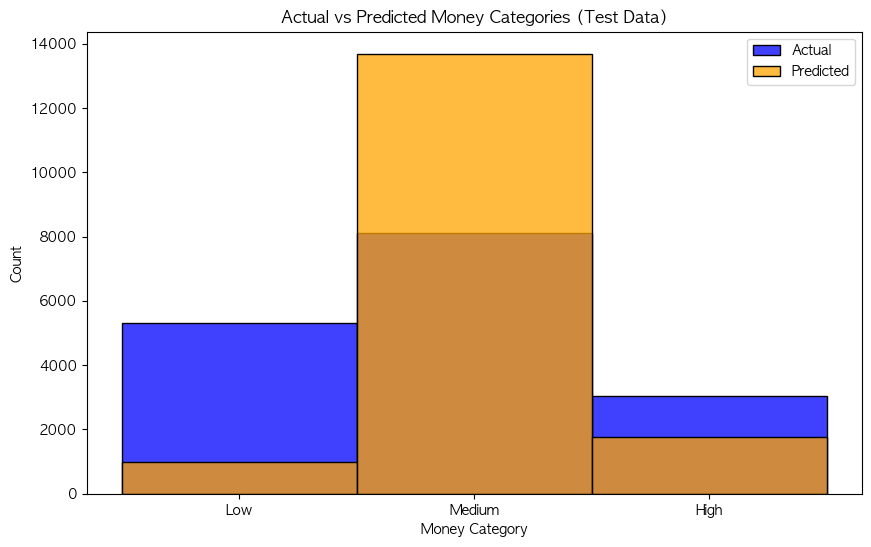

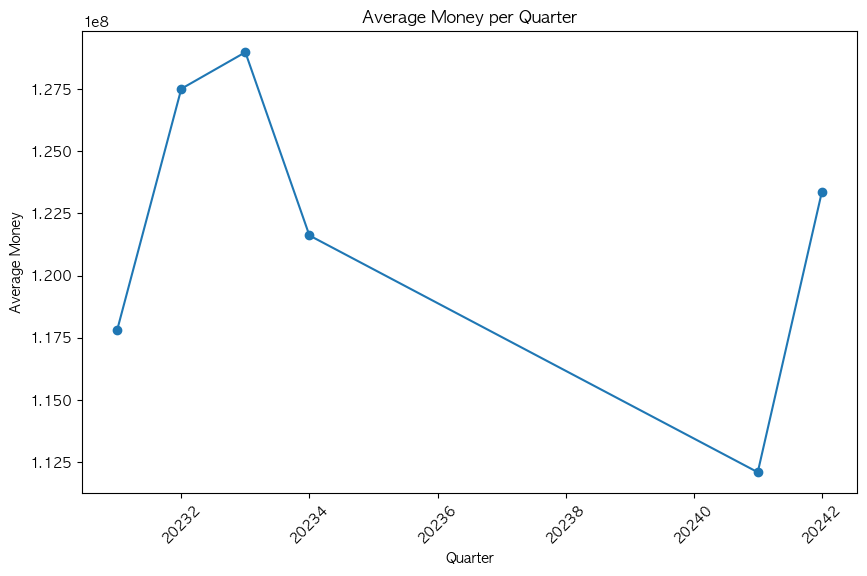

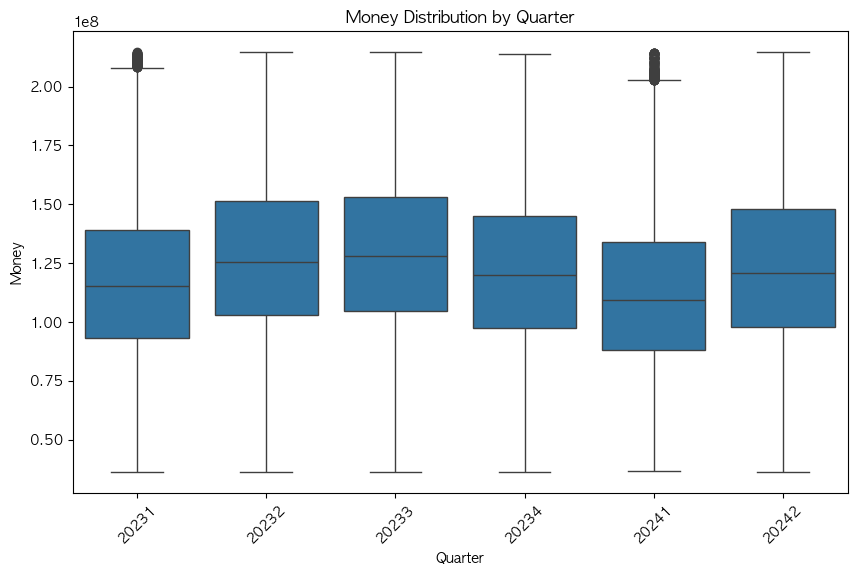

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
data = pd.read_csv('Data/95trusted.csv')

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data[features]
y = data['money']

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data[data['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data[data['quarter_num'] == 20234]
test_data = data[data['quarter_num'].isin([20241, 20242])]

X_train = train_data[features]
y_train = train_data['money']

X_val = validation_data[features]
y_val = validation_data['money']

X_test = test_data[features]
y_test = test_data['money']

# 매출액을 구간화하여 분류 문제로 변환 (Low, Medium, High)
bins = [0, 1e8, 1.5e8, np.inf]  # 구간 설정: 저매출(1억 이하), 중매출(1억~1.5억), 고매출(1.5억 이상)
labels = ['Low', 'Medium', 'High']  # 구간 라벨 설정

y_train_binned = pd.cut(y_train, bins=bins, labels=labels)
y_val_binned = pd.cut(y_val, bins=bins, labels=labels)
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

# 3. Gradient Boosting Classifier 모델 학습 및 하이퍼파라미터 튜닝 (Grid Search 사용)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

gbm_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train_binned)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 검증 데이터 예측 및 평가
best_gbm_model = grid_search.best_estimator_
y_val_pred = best_gbm_model.predict(X_val)
val_accuracy = accuracy_score(y_val_binned, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val_binned, y_val_pred))

# 테스트 데이터로 예측 및 평가
y_test_pred = best_gbm_model.predict(X_test)
test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_test_binned, y_test_pred))

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
sns.histplot(y_test_binned, color='blue', label='Actual', kde=False)
sns.histplot(y_test_pred, color='orange', label='Predicted', kde=False)
plt.title("Actual vs Predicted Money Categories (Test Data)")
plt.xlabel("Money Category")
plt.ylabel("Count")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Validation Accuracy: 0.7923330484678306
Validation Classification Report:
               precision    recall  f1-score   support

        High       0.73      0.88      0.80      1750
         Low       0.95      0.61      0.75      2265
      Medium       0.77      0.85      0.81      4176

    accuracy                           0.79      8191
   macro avg       0.82      0.78      0.78      8191
weighted avg       0.81      0.79      0.79      8191

Test Accuracy: 0.7108814589665654
Test Classification Report:
               precision    recall  f1-score   support

        High       0.61      0.85      0.71      3028
         Low       0.94      0.52      0.67      5311
      Medium       0.68      0.78      0.73      8111

    accuracy                           0.71     16450
   macro avg       0.74      0.72      0.70     16450
weighted avg

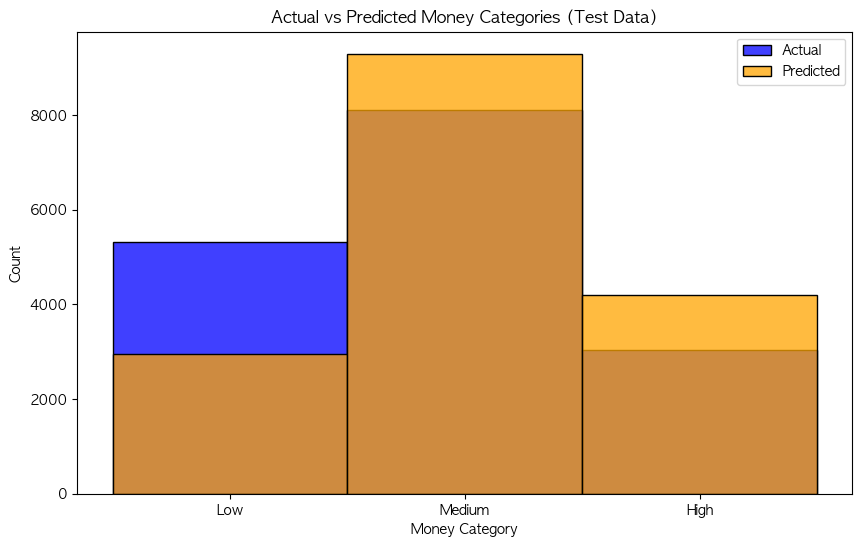

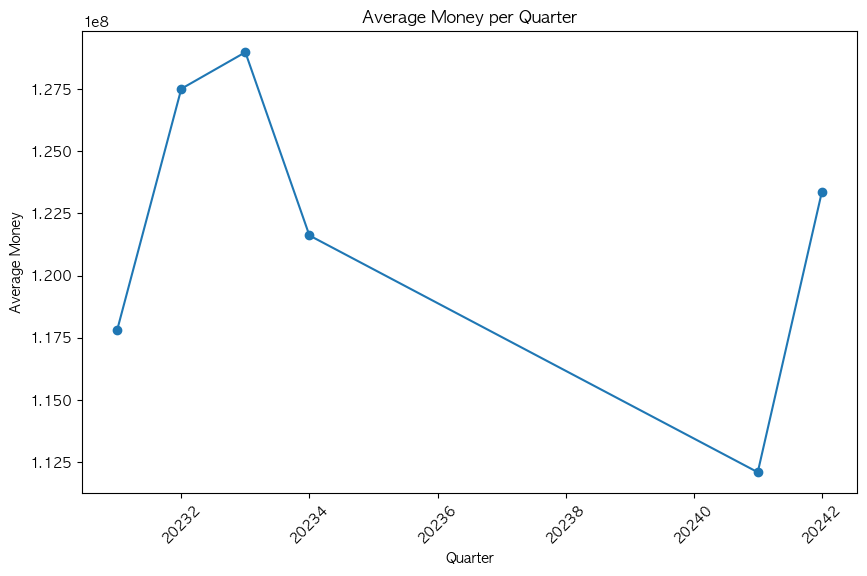

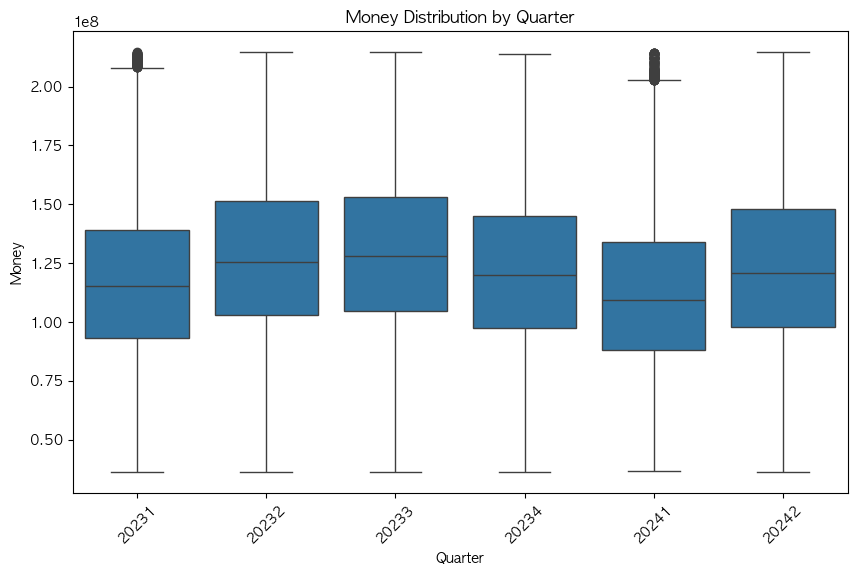

/Users/tj2/anaconda/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:287: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])


DateParseError: year 20241 is out of range: 20241, at position 0

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# 1. 데이터 로드 및 전처리 (IQR을 사용한 이상치 처리 포함)
data = pd.read_csv('Data/95trusted.csv')

# IQR을 사용한 이상치 제거 (money 컬럼 기준)
Q1 = data['money'].quantile(0.25)
Q3 = data['money'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내의 데이터만 선택 (이상치 제거)
data = data[~((data['money'] < (Q1 - 1.5 * IQR)) | (data['money'] > (Q3 + 1.5 * IQR)))]

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data[features]
y = data['money']

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data[data['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data[data['quarter_num'] == 20234]
test_data = data[data['quarter_num'].isin([20241, 20242])]

X_train = train_data[features]
y_train = train_data['money']

X_val = validation_data[features]
y_val = validation_data['money']

X_test = test_data[features]
y_test = test_data['money']

# 매출액을 구간화하여 분류 문제로 변환 (Low, Medium, High)
bins = [0, 1e8, 1.5e8, np.inf]  # 구간 설정: 저매출(1억 이하), 중매출(1억~1.5억), 고매출(1.5억 이상)
labels = ['Low', 'Medium', 'High']  # 구간 라벨 설정

y_train_binned = pd.cut(y_train, bins=bins, labels=labels)
y_val_binned = pd.cut(y_val, bins=bins, labels=labels)
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

# 3. Gradient Boosting Classifier 모델 학습 및 하이퍼파라미터 튜닝 (Grid Search 사용)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

gbm_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train_binned)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 검증 데이터 예측 및 평가
best_gbm_model = grid_search.best_estimator_
y_val_pred = best_gbm_model.predict(X_val)
val_accuracy = accuracy_score(y_val_binned, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val_binned, y_val_pred))

# 테스트 데이터로 예측 및 평가
y_test_pred = best_gbm_model.predict(X_test)
test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_test_binned, y_test_pred))

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
sns.histplot(y_test_binned, color='blue', label='Actual', kde=False)
sns.histplot(y_test_pred, color='orange', label='Predicted', kde=False)
plt.title("Actual vs Predicted Money Categories (Test Data)")
plt.xlabel("Money Category")
plt.ylabel("Count")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()

# 시계열 분석 추가 - Prophet 사용
df_prophet = data[['quarter_num', 'money']].rename(columns={'quarter_num': 'ds', 'money': 'y'})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future_dates = model_prophet.make_future_dataframe(periods=4)  # 향후 4분기 예측
forecast_prophet = model_prophet.predict(future_dates)

# 시계열 예측 결과 시각화
model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast for Future Quarters')
plt.show()


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation MSE: 457688659292433.6
Validation R2 Score: 0.6453621448398018
Test MSE: 615419778469399.1
Test R2 Score: 0.530769181263651


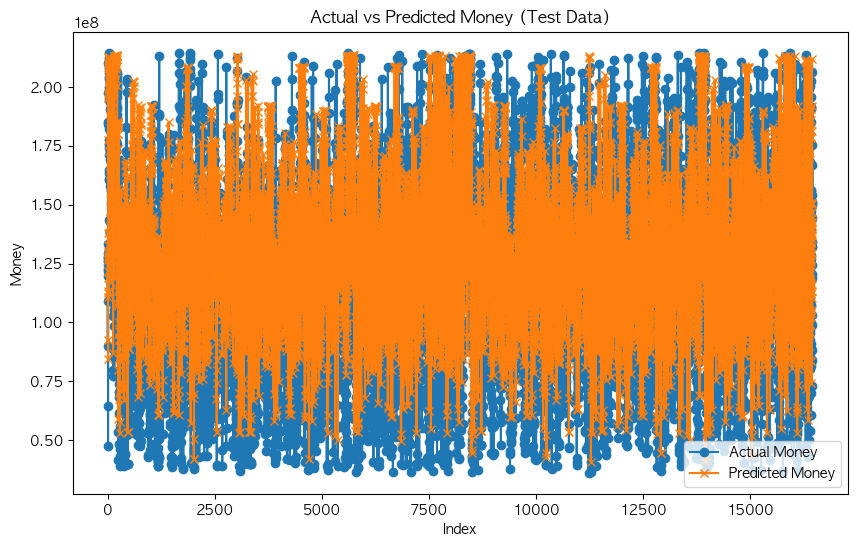

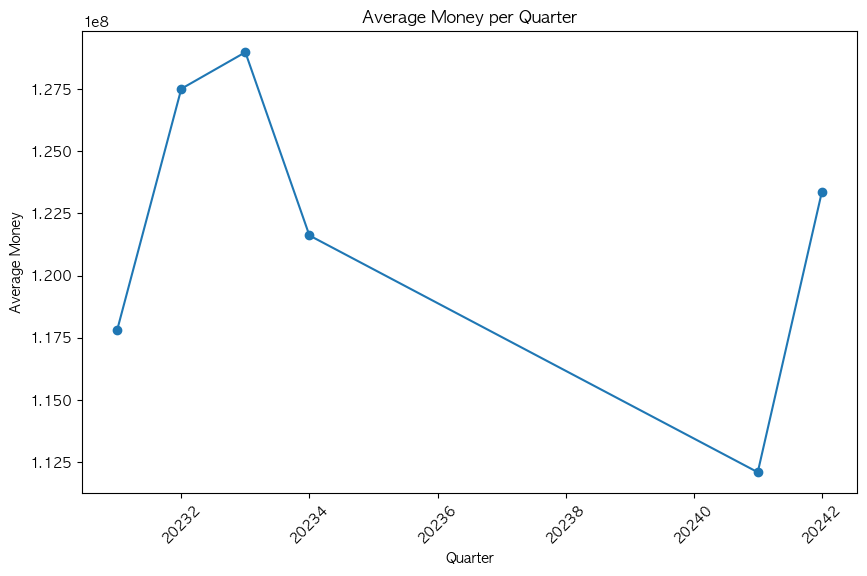

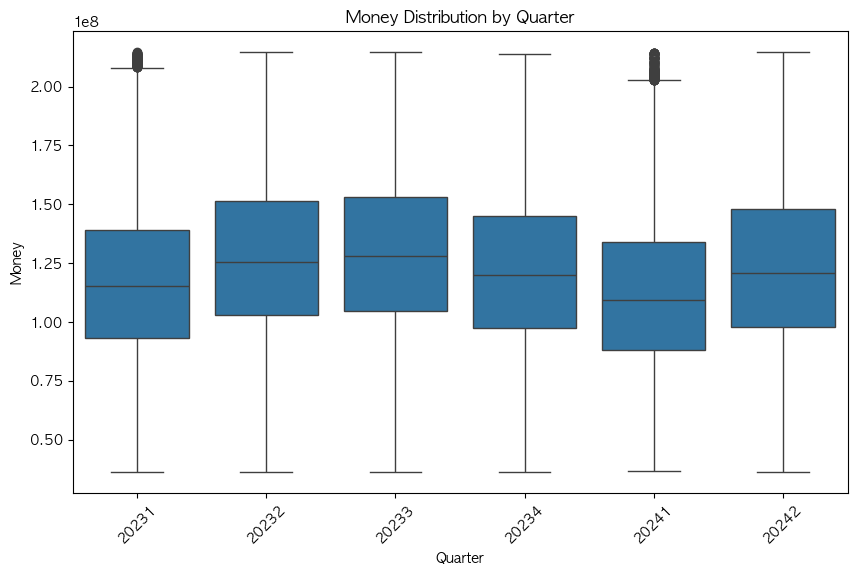

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리 (IQR을 사용한 이상치 처리 포함)
data = pd.read_csv('Data/95trusted.csv')

# IQR을 사용한 이상치 제거 (money 컬럼 기준)
Q1 = data['money'].quantile(0.25)
Q3 = data['money'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내의 데이터만 선택 (이상치 제거)
data_cleaned = data[~((data['money'] < (Q1 - 1.5 * IQR)) | (data['money'] > (Q3 + 1.5 * IQR)))]

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data_cleaned[features]
y = data_cleaned['money']

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data_cleaned[data_cleaned['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data_cleaned[data_cleaned['quarter_num'] == 20234]
test_data = data_cleaned[data_cleaned['quarter_num'].isin([20241, 20242])]

X_train = train_data[features]
y_train = train_data['money']

X_val = validation_data[features]
y_val = validation_data['money']

X_test = test_data[features]
y_test = test_data['money']

# 3. 회귀 모델 학습 및 하이퍼파라미터 튜닝 (Random Forest Regressor 사용)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 학습 및 검증 데이터 예측 및 평가
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

# 테스트 데이터로 예측 및 평가
y_test_pred = best_rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Money", marker='o')
plt.plot(y_test_pred, label="Predicted Money", marker='x')
plt.title("Actual vs Predicted Money (Test Data)")
plt.xlabel("Index")
plt.ylabel("Money")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data_cleaned)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/tj2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tj2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tj2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/tj2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation MSE: 0.03844931490829159
Validation R2 Score: 0.6261454645276086
Test MSE: 0.051455533184001874
Test R2 Score: 0.5264785251898616


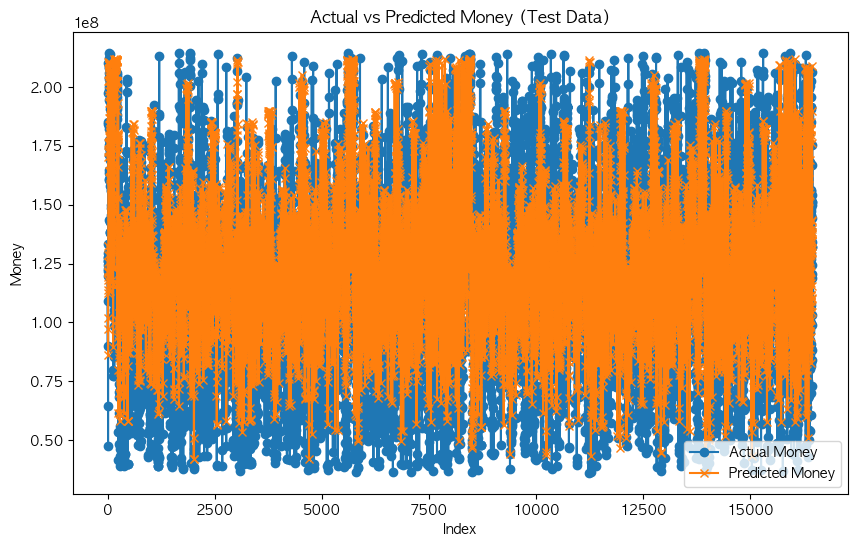

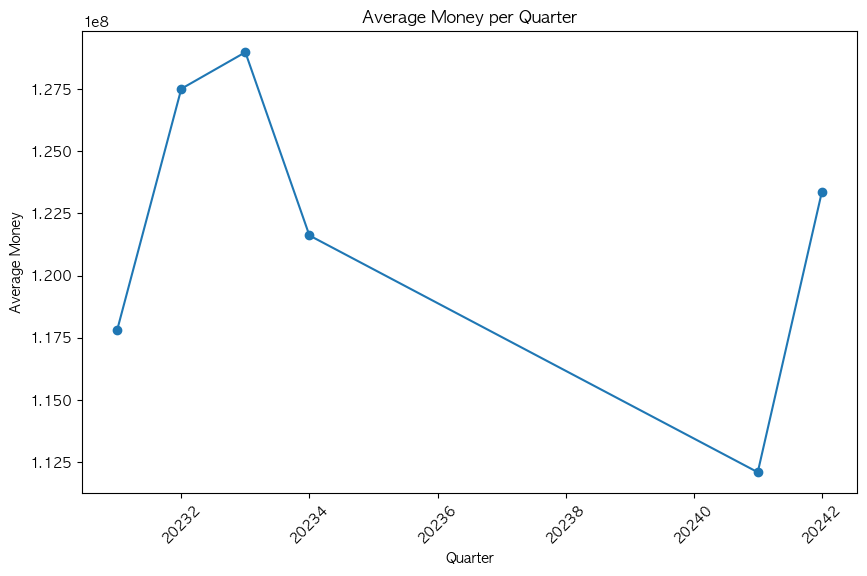

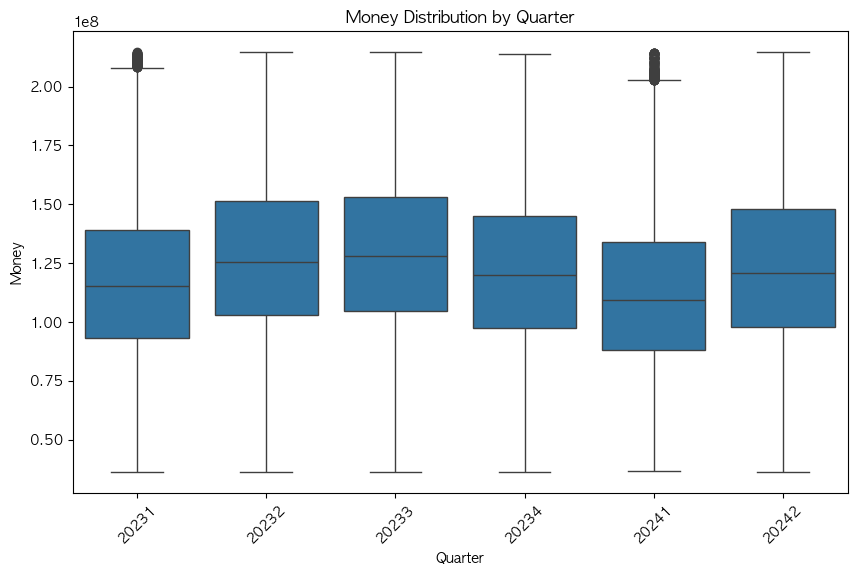

In [19]:


# IQR을 사용한 이상치 제거 (money 컬럼 기준)
Q1 = data['money'].quantile(0.25)
Q3 = data['money'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내의 데이터만 선택 (이상치 제거)
data_cleaned = data[~((data['money'] < (Q1 - 1.5 * IQR)) | (data['money'] > (Q3 + 1.5 * IQR)))]

# 로그 변환(Log Transformation)을 통해 매출액 분포 정규화
data_cleaned['money_log'] = np.log1p(data_cleaned['money'])  # log(1 + x)로 변환하여 음수값 방지

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data_cleaned[features]
y = data_cleaned['money_log']  # 로그 변환된 매출액 사용

# 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data_cleaned[data_cleaned['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data_cleaned[data_cleaned['quarter_num'] == 20234]
test_data = data_cleaned[data_cleaned['quarter_num'].isin([20241, 20242])]

X_train = scaler.fit_transform(train_data[features])
y_train = np.log1p(train_data['money'])  # 로그 변환된 매출액 사용

X_val = scaler.transform(validation_data[features])
y_val = np.log1p(validation_data['money'])  # 로그 변환된 매출액 사용

X_test = scaler.transform(test_data[features])
y_test = np.log1p(test_data['money'])  # 로그 변환된 매출액 사용

# 3. 회귀 모델 학습 및 하이퍼파라미터 튜닝 (Random Forest Regressor 사용)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']  # 추가적인 하이퍼파라미터 조정
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 학습 및 검증 데이터 예측 및 평가
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

# 테스트 데이터로 예측 및 평가
y_test_pred = best_rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
plt.plot(np.expm1(y_test), label="Actual Money", marker='o')  # 로그 변환 복원
plt.plot(np.expm1(y_test_pred), label="Predicted Money", marker='x')  # 로그 변환 복원
plt.title("Actual vs Predicted Money (Test Data)")
plt.xlabel("Index")
plt.ylabel("Money")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data_cleaned)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation MSE: 0.03844931490829159
Validation R2 Score: 0.6261454645276086
Test MSE: 0.051455533184001874
Test R2 Score: 0.5264785251898616


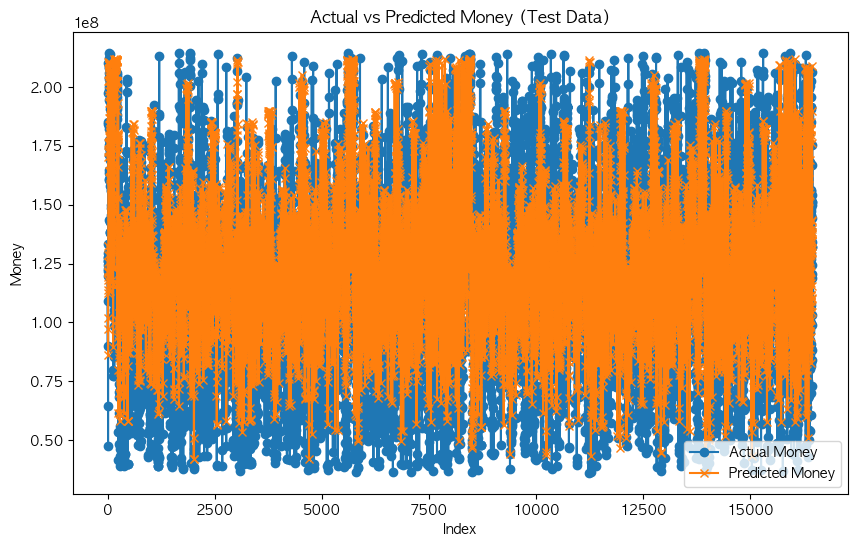

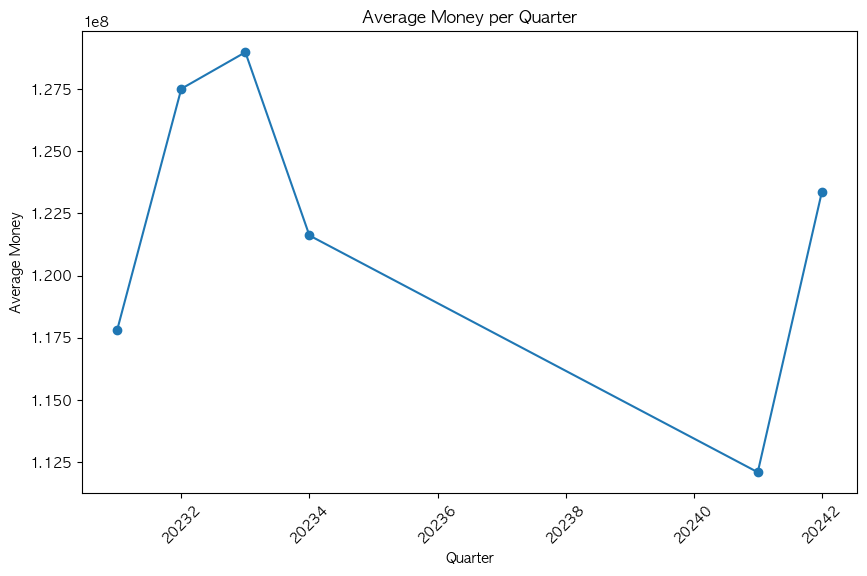

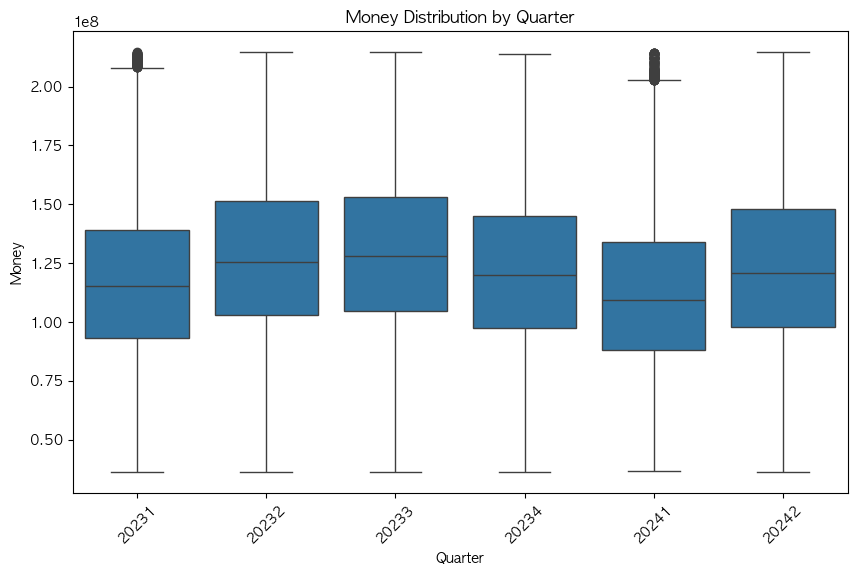

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리 (IQR을 사용한 이상치 처리 포함)
data = pd.read_csv('Data/95trusted.csv')

# IQR을 사용한 이상치 제거 (money 컬럼 기준)
Q1 = data['money'].quantile(0.25)
Q3 = data['money'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내의 데이터만 선택 (이상치 제거)
data_cleaned = data[~((data['money'] < (Q1 - 1.5 * IQR)) | (data['money'] > (Q3 + 1.5 * IQR)))]

# 로그 변환(Log Transformation)을 통해 매출액 분포 정규화
data_cleaned['money_log'] = np.log1p(data_cleaned['money'])  # log(1 + x)로 변환하여 음수값 방지

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data_cleaned[features]
y = data_cleaned['money_log']  # 로그 변환된 매출액 사용

# 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data_cleaned[data_cleaned['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data_cleaned[data_cleaned['quarter_num'] == 20234]
test_data = data_cleaned[data_cleaned['quarter_num'].isin([20241, 20242])]

X_train = scaler.fit_transform(train_data[features])
y_train = np.log1p(train_data['money'])  # 로그 변환된 매출액 사용

X_val = scaler.transform(validation_data[features])
y_val = np.log1p(validation_data['money'])  # 로그 변환된 매출액 사용

X_test = scaler.transform(test_data[features])
y_test = np.log1p(test_data['money'])  # 로그 변환된 매출액 사용

# 3. 회귀 모델 학습 및 하이퍼파라미터 튜닝 (Random Forest Regressor 사용)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']  # auto 제거 후 sqrt와 log2만 사용
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 학습 및 검증 데이터 예측 및 평가
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

# 테스트 데이터로 예측 및 평가
y_test_pred = best_rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
plt.plot(np.expm1(y_test), label="Actual Money", marker='o')  # 로그 변환 복원
plt.plot(np.expm1(y_test_pred), label="Predicted Money", marker='x')  # 로그 변환 복원
plt.title("Actual vs Predicted Money (Test Data)")
plt.xlabel("Index")
plt.ylabel("Money")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data_cleaned)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation MSE: 0.03844931490829159
Validation R2 Score: 0.6261454645276086
Test MSE: 0.051455533184001874
Test R2 Score: 0.5264785251898616


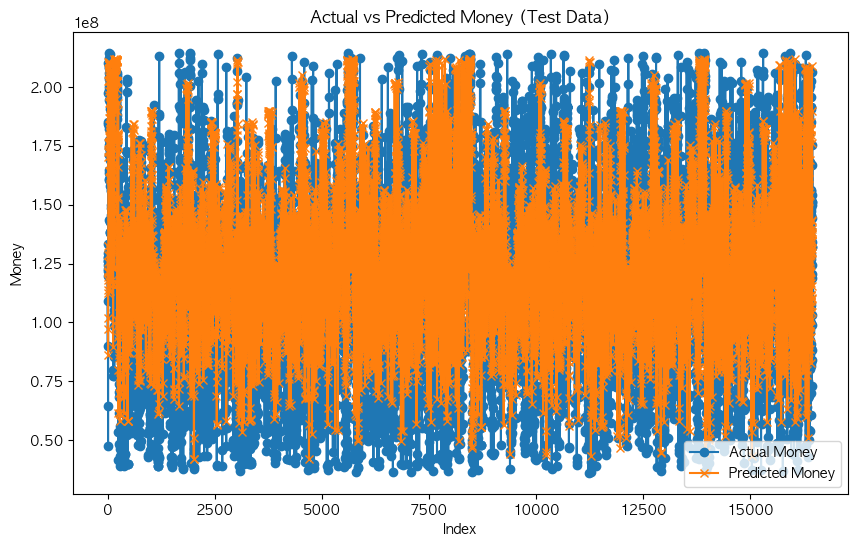

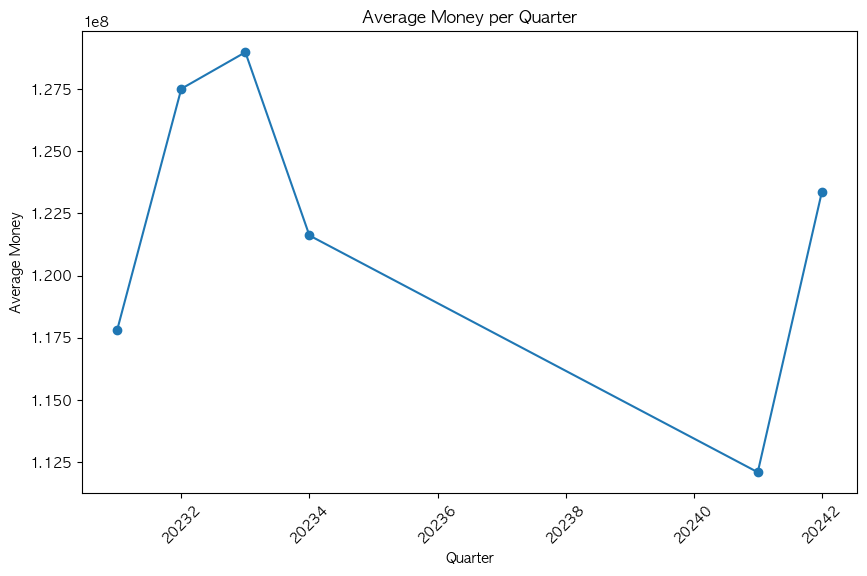

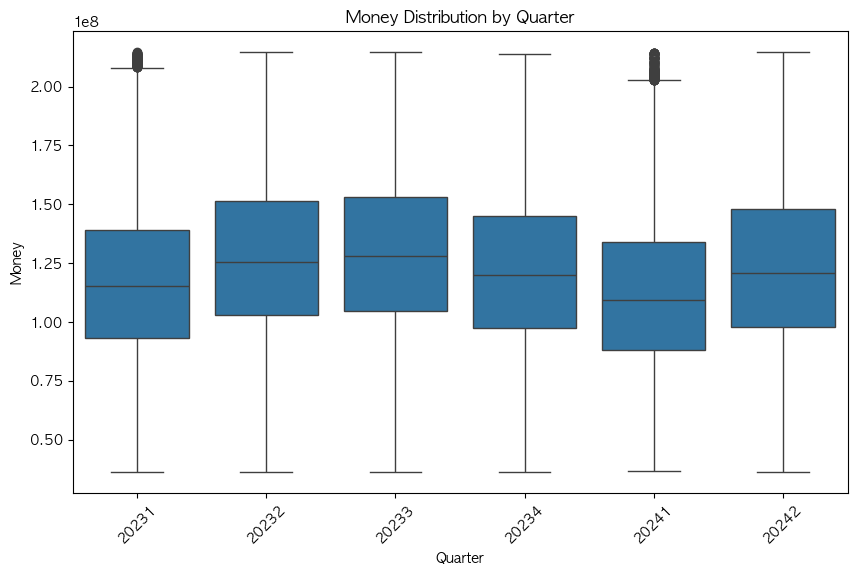

In [21]:

# IQR을 사용한 이상치 제거 (money 컬럼 기준)
Q1 = data['money'].quantile(0.25)
Q3 = data['money'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내의 데이터만 선택 (이상치 제거)
data_cleaned = data[~((data['money'] < (Q1 - 1.5 * IQR)) | (data['money'] > (Q3 + 1.5 * IQR)))]

# 로그 변환(Log Transformation)을 통해 매출액 분포 정규화
data_cleaned['money_log'] = np.log1p(data_cleaned['money'])  # log(1 + x)로 변환하여 음수값 방지

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter_num']  # 쿼터 변수 포함

X = data_cleaned[features]
y = data_cleaned['money_log']  # 로그 변환된 매출액 사용

# 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train/Validation/Test Split (시간 순서대로 분리)
train_data = data_cleaned[data_cleaned['quarter_num'].isin([20231, 20232, 20233])]
validation_data = data_cleaned[data_cleaned['quarter_num'] == 20234]
test_data = data_cleaned[data_cleaned['quarter_num'].isin([20241, 20242])]

X_train = scaler.fit_transform(train_data[features])
y_train = np.log1p(train_data['money'])  # 로그 변환된 매출액 사용

X_val = scaler.transform(validation_data[features])
y_val = np.log1p(validation_data['money'])  # 로그 변환된 매출액 사용

X_test = scaler.transform(test_data[features])
y_test = np.log1p(test_data['money'])  # 로그 변환된 매출액 사용

# 3. 회귀 모델 학습 및 하이퍼파라미터 튜닝 (Random Forest Regressor 사용)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']  # auto 제거 후 sqrt와 log2만 사용
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

# 최적의 모델로 학습 및 검증 데이터 예측 및 평가
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

# 테스트 데이터로 예측 및 평가
y_test_pred = best_rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
plt.plot(np.expm1(y_test), label="Actual Money", marker='o')  # 로그 변환 복원
plt.plot(np.expm1(y_test_pred), label="Predicted Money", marker='x')  # 로그 변환 복원
plt.title("Actual vs Predicted Money (Test Data)")
plt.xlabel("Index")
plt.ylabel("Money")
plt.legend()
plt.show()

# 추가 시각화 - 분기별 매출액 평균 변화
average_money_per_quarter = data.groupby('quarter_num')['money'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(average_money_per_quarter['quarter_num'], average_money_per_quarter['money'], marker='o')
plt.title('Average Money per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Money')
plt.xticks(rotation=45)
plt.show()

# 추가 시각화 - 분기별 매출액 분포 (박스플롯)
plt.figure(figsize=(10,6))
sns.boxplot(x='quarter_num', y='money', data=data_cleaned)
plt.title('Money Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Money')
plt.xticks(rotation=45)
plt.show()
